In [1]:
import os
import numpy as np
import pandas as pd

from modulation_utils import get_selected_channel_idxes, extract_emotion_psd_features, train_emotion_classifier

fs = 250
pre_eeg_path = r"/mnt/dataset0/xkp/closed-loop/server/pre_eeg_1"

labels = np.load(r"/mnt/dataset0/xkp/closed-loop/server/pre_eeg_1/labels.npy")
print(f"Loaded labels: {labels}")

eeg_files = [f for f in os.listdir(pre_eeg_path) 
             if f.endswith('.npy') and f != 'labels.npy']

if len(eeg_files) != len(labels):
    print(f"Number of EEG files ({len(eeg_files)}) does not match number of labels ({len(labels)})")

# 加载EEG数据
eeg_file_paths = [os.path.join(pre_eeg_path, f) for f in eeg_files]
eeg_data = np.array([np.load(file) for file in eeg_file_paths])  # (n_samples, n_channels, n_timepoints)

print(f"Loaded {len(eeg_data)} EEG samples with shape {eeg_data.shape}")

Loaded labels: ['Dis' 'Ten' 'Sad' 'Sad' 'Neu' 'Amu' 'Amu' 'Fea' 'Sad' 'Ten' 'Sad' 'Fea'
 'Neu' 'Ins' 'Dis' 'Neu' 'Sad' 'Fea' 'Ins' 'Amu' 'Sad' 'Ins' 'Ten' 'Ins'
 'Sad' 'Ins' 'Sad' 'Dis' 'Fea' 'Ten' 'Ten' 'Neu' 'Dis' 'Dis' 'Neu' 'Ins'
 'Ins' 'Fea' 'Ten' 'Dis' 'Fea' 'Ten' 'Dis' 'Amu' 'Sad' 'Ins' 'Ten' 'Amu'
 'Ten' 'Ten' 'Fea' 'Dis' 'Amu' 'Fea' 'Sad' 'Dis' 'Dis' 'Amu' 'Ten' 'Fea'
 'Amu' 'Amu' 'Sad' 'Amu' 'Amu' 'Fea' 'Amu' 'Neu' 'Neu' 'Ins' 'Sad' 'Amu'
 'Sad' 'Neu' 'Fea' 'Ins' 'Sad' 'Fea' 'Ins' 'Ten' 'Ins' 'Ten' 'Neu' 'Ins'
 'Dis' 'Dis' 'Ins' 'Neu' 'Neu' 'Fea' 'Neu' 'Ins' 'Fea' 'Dis' 'Ten' 'Neu'
 'Sad' 'Dis' 'Neu' 'Neu' 'Amu' 'Ten' 'Fea' 'Amu' 'Dis']
Loaded 105 EEG samples with shape (105, 64, 250)


In [2]:
# 获取选定的通道
selected_channel_idxes = get_selected_channel_idxes(eeg_data, fs)
print("Selected channels:", selected_channel_idxes)

# 提取特征并训练分类器
features, valid_labels = extract_emotion_psd_features(eeg_data, labels, fs, selected_channel_idxes)
clf, report, y_test, y_pred= train_emotion_classifier(features, valid_labels, 0.2, 42)
print("Classifier report:")
print(report)

/home/xkp/miniconda3/envs/BCI/lib/python3.10/site-packages/joblib/parallel.py:1792: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  res = func(*args, **kwargs)
/home/xkp/miniconda3/envs/BCI/lib/python3.10/site-packages/joblib/parallel.py:1792: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  res = func(*args, **kwargs)
/home/xkp/miniconda3/envs/BCI/lib/python3.10/site-packages/joblib/parallel.py:1792: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  res = func(*args, **kwargs)
/home/xkp/miniconda3/envs/BCI/lib/python3.10/site-packages/joblib/parallel.py:1792: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  res = func(*args, **kwargs)
/home/xkp/miniconda3/envs/BCI/lib/python3.10/site-packages/joblib/parallel.py:1792: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  res = func(*args, **kwargs)
/home/xkp/miniconda3/envs/BCI/lib/python3.10/site-packages/joblib/para

Selected channels: [21, 32, 30]
========= Extracting features from 105 samples =========
最佳参数: {'classifier__max_depth': None, 'classifier__min_samples_split': 2, 'classifier__n_estimators': 100}
Classifier report:
              precision    recall  f1-score   support

           0       0.69      0.75      0.72        12
           1       0.62      0.56      0.59         9

    accuracy                           0.67        21
   macro avg       0.66      0.65      0.65        21
weighted avg       0.66      0.67      0.66        21



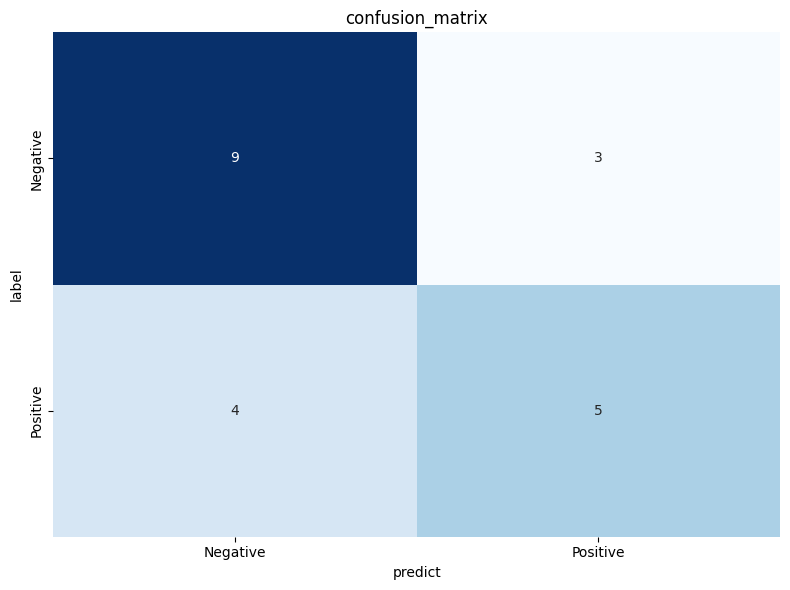

图表已保存到当前目录


<Figure size 1000x600 with 0 Axes>

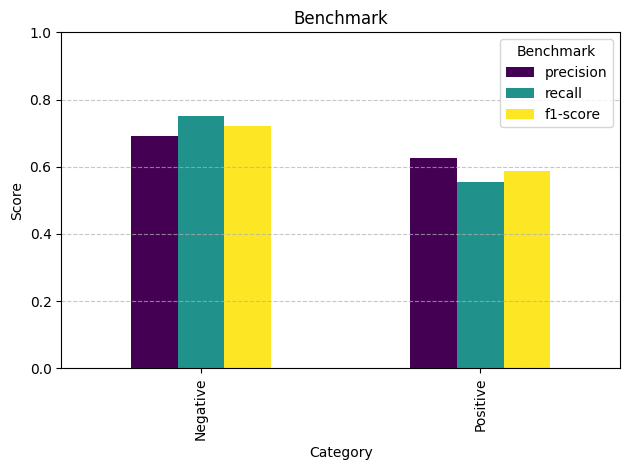

In [3]:
# 使用 pandas 生成打印报告并绘制图表
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# 1. 混淆矩阵可视化
cm = confusion_matrix(y_test, y_pred)
class_names = ['Negative', 'Positive']
cm_df = pd.DataFrame(cm, index=class_names, columns=class_names)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('confusion_matrix')
plt.ylabel('label')
plt.xlabel('predict')
plt.tight_layout()
plt.savefig('confusion_matrix.png')
plt.show()

# 2. 性能指标条形图
report_dict = classification_report(y_test, y_pred, output_dict=True)
df_report = pd.DataFrame(report_dict).transpose()
df_metrics = df_report.iloc[:-3]
df_metrics = df_metrics.rename(index={'0': 'Negative', '1': 'Positive'})

metrics = ['precision', 'recall', 'f1-score']
df_plot = df_metrics[metrics]

plt.figure(figsize=(10, 6))
df_plot.plot(kind='bar', colormap='viridis')
plt.title('Benchmark')
plt.ylabel('Score')
plt.xlabel('Category')
plt.ylim(0, 1.0)
plt.legend(title='Benchmark')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig('metrics_chart.png')
print("图表已保存到当前目录")